# Estimate strain growth advantages using MLR

Import modules including [evofr](https://blab.github.io/evofr/) and get variables from `snakemake`:

In [1]:
######## snakemake preamble start (automatically inserted, do not edit) ########
import sys;sys.path.extend(['/fh/fast/bloom_j/software/miniforge3/envs/flu_H3_2023-2024_strains_MLR/lib/python3.12/site-packages', '/fh/fast/bloom_j/computational_notebooks/jbloom/2024/flu_H3_2023-2024_strains_MLR', '/fh/fast/bloom_j/software/miniforge3/envs/flu_H3_2023-2024_strains_MLR/bin', '/fh/fast/bloom_j/software/miniforge3/envs/flu_H3_2023-2024_strains_MLR/lib/python3.12', '/fh/fast/bloom_j/software/miniforge3/envs/flu_H3_2023-2024_strains_MLR/lib/python3.12/lib-dynload', '/fh/fast/bloom_j/software/miniforge3/envs/flu_H3_2023-2024_strains_MLR/lib/python3.12/site-packages', '/fh/fast/bloom_j/software/miniforge3/envs/flu_H3_2023-2024_strains_MLR/lib/python3.12/site-packages/setuptools/_vendor', '/home/jbloom/.cache/snakemake/snakemake/source-cache/runtime-cache/tmph4msxsbz/file/fh/fast/bloom_j/computational_notebooks/jbloom/2024/flu_H3_2023-2024_strains_MLR/notebooks', '/fh/fast/bloom_j/computational_notebooks/jbloom/2024/flu_H3_2023-2024_strains_MLR/notebooks']);import pickle;from snakemake import script;script.snakemake = pickle.loads(b'\x80\x04\x95\x96\x07\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94\x8c5results/strain_counts/gisaid-ha1_1_counts_by_date.csv\x94a}\x94(\x8c\x06_names\x94}\x94\x8c\x0ecounts_by_date\x94K\x00N\x86\x94s\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x12h\x06\x8c\x0eAttributeGuard\x94\x93\x94)\x81\x94}\x94\x8c\x04name\x94h\x12sbh\x13h\x15)\x81\x94}\x94h\x18h\x13sbh\x0eh\nub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8cDresults/mlr/strain_counts_gisaid-ha1_1_2023-01-01-to-2024-03-01.html\x94\x8cCresults/mlr/counts_to_fit_gisaid-ha1_1_2023-01-01-to-2024-03-01.csv\x94e}\x94(h\x0c}\x94(\x8c\x0ccounts_chart\x94K\x00N\x86\x94\x8c\rcounts_to_fit\x94K\x01N\x86\x94uh\x10]\x94(h\x12h\x13eh\x12h\x15)\x81\x94}\x94h\x18h\x12sbh\x13h\x15)\x81\x94}\x94h\x18h\x13sbh#h\x1fh%h ub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(K2K\x0e\x8c\x16A/Ontario/RV00796/2023\x94e}\x94(h\x0c}\x94(\x8c\nmin_counts\x94K\x00N\x86\x94\x8c\x16plot_window_frame_days\x94K\x01N\x86\x94\x8c\x0cpivot_strain\x94K\x02N\x86\x94uh\x10]\x94(h\x12h\x13eh\x12h\x15)\x81\x94}\x94h\x18h\x12sbh\x13h\x15)\x81\x94}\x94h\x18h\x13sbh3K2h5K\x0eh7h0ub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94(\x8c\ngisaid-ha1\x94\x8c\x011\x94\x8c\x182023-01-01-to-2024-03-01\x94e}\x94(h\x0c}\x94(\x8c\x07protset\x94K\x00N\x86\x94\x8c\x07maxdiff\x94K\x01N\x86\x94\x8c\tdaterange\x94K\x02N\x86\x94uh\x10]\x94(h\x12h\x13eh\x12h\x15)\x81\x94}\x94h\x18h\x12sbh\x13h\x15)\x81\x94}\x94h\x18h\x13sb\x8c\x07protset\x94hB\x8c\x07maxdiff\x94hC\x8c\tdaterange\x94hDub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01\x8c\x04/tmp\x94e}\x94(h\x0c}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94\x8c\x06tmpdir\x94K\x02N\x86\x94uh\x10]\x94(h\x12h\x13eh\x12h\x15)\x81\x94}\x94h\x18h\x12sbh\x13h\x15)\x81\x94}\x94h\x18h\x13sbh]K\x01h_K\x01hahZub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c;results/mlr/mlr_gisaid-ha1_1_2023-01-01-to-2024-03-01.ipynb\x94a}\x94(h\x0c}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh\x10]\x94(h\x12h\x13eh\x12h\x15)\x81\x94}\x94h\x18h\x12sbh\x13h\x15)\x81\x94}\x94h\x18h\x13sbhohlub\x8c\x06config\x94}\x94(\x8c\x0cstrain_prots\x94\x8c(data/H3_library_constructs_protein.fasta\x94\x8c\x08protsets\x94}\x94(\x8c\x0fncbi-ectodomain\x94}\x94(\x8c\x07protset\x94\x8c\x19data/ncbi_flu_h3_prots.fa\x94\x8c\x04trim\x94]\x94(K\x14M\x15\x02eu\x8c\x11gisaid-ectodomain\x94}\x94(\x8c\x07protset\x94\x8c\x1bdata/gisaid_flu_h3_prots.fa\x94\x8c\x04trim\x94]\x94(K\x14M\x15\x02eu\x8c\x08ncbi-ha1\x94}\x94(\x8c\x07protset\x94\x8c\x19data/ncbi_flu_h3_prots.fa\x94\x8c\x04trim\x94]\x94(K\x14M\\\x01eu\x8c\ngisaid-ha1\x94}\x94(\x8c\x07protset\x94\x8c\x1bdata/gisaid_flu_h3_prots.fa\x94\x8c\x04trim\x94]\x94(K\x14M\\\x01euu\x8c\x10protset_maxdiffs\x94]\x94(K\x00K\x01e\x8c\nmin_counts\x94K2\x8c\x16plot_window_frame_days\x94K\x0e\x8c\ndateranges\x94]\x94(\x8c\x182022-01-01-to-2024-08-01\x94\x8c\x182023-01-01-to-2024-03-01\x94e\x8c\x0cpivot_strain\x94h0u\x8c\x04rule\x94\x8c\x03mlr\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c[/fh/fast/bloom_j/computational_notebooks/jbloom/2024/flu_H3_2023-2024_strains_MLR/notebooks\x94ub.');del script;from snakemake.logging import logger;from snakemake.script import snakemake; logger.printshellcmds = False;import os; os.chdir(r'/fh/fast/bloom_j/computational_notebooks/jbloom/2024/flu_H3_2023-2024_strains_MLR');
######## snakemake preamble end #########


In [25]:
import re

import altair as alt

import evofr
import evofr.plotting

import matplotlib.pyplot as plt

import pandas as pd

_ = alt.data_transformers.disable_max_rows()

In [20]:
# get variables from `snakemake`
counts_by_date_csv = snakemake.input.counts_by_date

counts_chart_html = snakemake.output.counts_chart
counts_to_fit_csv = snakemake.output.counts_to_fit

wildcards_desc = ", ".join(f"{key}={val}" for (key, val) in snakemake.wildcards.items())
print(f"{wildcards_desc=}")

min_counts = snakemake.params.min_counts

plot_window_frame_days = snakemake.params.plot_window_frame_days

date_start, date_end = snakemake.wildcards.daterange.split("-to-")
assert all(re.fullmatch(r"\d{4}\-\d{2}\-\d{2}", d) for d in [date_start, date_end])

pivot_strain = snakemake.params.pivot_strain

mlr_tau = 3.6  # n

wildcards_desc='protset=gisaid-ha1, maxdiff=1, daterange=2023-01-01-to-2024-03-01'


## Counts for each strain by date

Read data.
We filter for counts within the specified date range, and then filter for strains that have sufficient counts in that range.
At the end of this, strains fall in one of three categories:
 - a named library strain (eg, *A/Bhutan/0845/2023*)
 - *strain not in library*: does not match a strain in library
 - *library strains with insufficient counts*: strains in the library with insufficient counts

In [4]:
NOT_IN_LIBRARY = "strain not in library"
INSUFFICIENT_COUNTS = "library strains insufficient counts"

all_counts_by_date = (
    pd.read_csv(counts_by_date_csv, parse_dates=["date"])
    .sort_values(["date", "variant"])
)

datetime_start = pd.to_datetime(date_start)
datetime_end = pd.to_datetime(date_end)
assert datetime_start < datetime_end

if datetime_start < all_counts_by_date["date"].min():
    raise ValueError(f"{datetime_start=} before {all_counts_by_date['date'].min()=}")
if datetime_end > all_counts_by_date["date"].max():
    raise ValueError(f"{datetime_start=} after {all_counts_by_date['date'].max()=}")

print(f"Trimming counts by date to the range {date_start=} to {date_end=}")
all_counts_by_date = all_counts_by_date[
    (all_counts_by_date["date"] >= datetime_start)
    & (all_counts_by_date["date"] <= datetime_end)
]

assert "other" in set(all_counts_by_date["variant"])
assert NOT_IN_LIBRARY not in set(all_counts_by_date["variant"])
all_counts_by_date["variant"] = all_counts_by_date["variant"].replace(
    "other", NOT_IN_LIBRARY
)

Trimming counts by date to the range date_start='2023-01-01' to date_end='2024-03-01'


Get total counts for each variant:

In [5]:
total_counts = (
    all_counts_by_date
    .groupby("variant", as_index=False)
    .aggregate(total_sequences=pd.NamedAgg("sequences", "sum"))
    .assign(sufficient_counts=lambda x: x["total_sequences"] >= min_counts)
)

total_counts_chart = (
    alt.Chart(total_counts)
    .encode(
        alt.X(
            "variant",
            sort=alt.SortField("total_sequences", order="descending"),
            title=None,
        ),
        alt.Y(
            "total_sequences",
            scale=alt.Scale(type="symlog", constant=50),
            title="total sequences",
            axis=alt.Axis(grid=False),
        ),
        alt.Fill(
            "sufficient_counts",
            scale=alt.Scale(range=["gray", "white"], domain=[True, False]),
            title="sufficient counts?",
            legend=alt.Legend(orient="top-right", offset=3)
        ),
        tooltip=total_counts.columns.tolist(),
    )
    .mark_bar(stroke="black")
    .properties(
        height=150,
        width=alt.Step(11),
        title=f"total sequences per strain from {date_start} to {date_end}",
    )
)

total_counts_chart

alt.Chart(...)

Now filter the counts by date to group all library strains with insufficient counts.
Also pad any missing dates in the range:

In [6]:
strains_w_insufficient_counts = set(
    total_counts
    .query("(not sufficient_counts) and variant != @NOT_IN_LIBRARY")
    ["variant"]
)

print(f"Grouping {len(strains_w_insufficient_counts)=} to '{INSUFFICIENT_COUNTS}'")

assert INSUFFICIENT_COUNTS not in set(all_counts_by_date["variant"])

# group strains w insufficient counts and pad zero counts on days w no counts
filtered_counts_by_date = (
    all_counts_by_date
    .assign(
        variant=lambda x: x["variant"].map(
            lambda v: INSUFFICIENT_COUNTS if v in strains_w_insufficient_counts else v
        ),
        day=lambda x: (x["date"] - datetime_start).dt.days,
    )
    .groupby(["variant", "day"], as_index=False)
    .aggregate({"sequences": "sum"})
    .sort_values(["day", "variant"])
)

days = filtered_counts_by_date["day"].unique()
assert all(days == days.astype(int)), "dates not all rounded to day"

print(f"Padding with zero counts any missing days between {date_start} and {date_end}")
filtered_counts_by_date = (
    filtered_counts_by_date
    .merge(
        pd.DataFrame(
            [(v, d) for v in filtered_counts_by_date["variant"].unique() for d in days],
            columns=["variant", "day"],
        ),
        how="outer",
        validate="one_to_one",
    )
    .assign(
        sequences=lambda x: x["sequences"].fillna(0),
        date=lambda x: x["day"].map(lambda d: datetime_start + pd.Timedelta(days=d)),
    )
    .drop(columns="day")
)

Grouping len(strains_w_insufficient_counts)=41 to 'library strains insufficient counts'
Padding with zero counts any missing days between 2023-01-01 and 2024-03-01


Plot number of strains in each group as a function of date:

In [7]:
# we create an integer days columns so we can impute missing days
grouped_counts_by_date = (
    filtered_counts_by_date
    .assign(
        set_of_strains=lambda x: x["variant"].map(
            lambda v: (
                "library strains"
                if v not in {INSUFFICIENT_COUNTS, NOT_IN_LIBRARY}
                else v
            ),
        )
    )
    .groupby(["set_of_strains", "date"], as_index=False)
    .aggregate({"sequences": "sum"})
)

grouped_counts_by_date_chart = (
    alt.Chart(grouped_counts_by_date)
    .transform_window(
        count="mean(sequences)",
        groupby=["set_of_strains"],
        frame=[-plot_window_frame_days, plot_window_frame_days],
    )
    .transform_joinaggregate(total_count="sum(count)", groupby=["date"])
    .transform_calculate(fraction=alt.datum.count / alt.datum.total_count)
    .transform_fold(
        fold=["count", "fraction"],
        as_=["statistic", "count_or_fraction"],
    )
    .encode(
        alt.X("date", title=None, axis=alt.Axis(grid=False, format="%b-%Y", labelAngle=-90)),
        alt.Y(
            "count_or_fraction:Q",
            axis=alt.Axis(grid=False),
            title=None,
            scale=alt.Scale(nice=False)
        ),
        alt.Fill(
            "set_of_strains",
            title="set of strains",
            legend=alt.Legend(orient="top", labelLimit=500, titleOrient="left"),
        ),
        alt.Column(
            "statistic:N",
            title=None,
            header=alt.Header(orient="left", labelFontStyle="bold", labelFontSize=11)
        ),
        tooltip=[
            "set_of_strains",
            "date",
            "statistic:N",
            alt.Tooltip("count_or_fraction:Q", format=".2f"),
        ],
    )
    .mark_area()
    .properties(
        width=350,
        height=160,
        title=alt.TitleParams(
            (
                "count or fraction of sequences in each set of strains "
                f"(rolling mean +/- {plot_window_frame_days} days)"
            ),
            anchor="middle",
        )
    )
    .resolve_scale(y="independent")
)

grouped_counts_by_date_chart

alt.Chart(...)

Now make per-strain plots:

In [8]:
statistic_selection = alt.selection_point(
    fields=["statistic"],
    bind=alt.binding_radio(
        options=["count", "fraction"],
        name="show count or fraction on y-axis?",
    ),
    value="fraction",
)

include_not_in_library = alt.param(
    bind=alt.binding_radio(
        options=[True, False],
        name=f"include {NOT_IN_LIBRARY}?",
    ),
    value=True,
)

include_insufficient_counts = alt.param(
    bind=alt.binding_radio(
        options=[True, False],
        name=f"include {INSUFFICIENT_COUNTS}?",
    ),
    value=True,
) 

counts_by_date_chart = (
    alt.Chart(filtered_counts_by_date)
    .add_params(statistic_selection, include_not_in_library, include_insufficient_counts)
    .transform_filter((alt.datum["variant"] != NOT_IN_LIBRARY) | include_not_in_library)
    .transform_filter((alt.datum["variant"] != INSUFFICIENT_COUNTS) | include_insufficient_counts)
    .transform_window(
        count="mean(sequences)",
        groupby=["variant"],
        frame=[-plot_window_frame_days, plot_window_frame_days],
    )
    .transform_joinaggregate(total_count="sum(count)", groupby=["date"])
    .transform_calculate(fraction=alt.datum.count / alt.datum.total_count)
    .transform_fold(
        fold=["count", "fraction"],
        as_=["statistic", "count_or_fraction"],
    )
    .transform_filter(statistic_selection)
    .encode(
        alt.X("date", title=None, axis=alt.Axis(grid=False, format="%b-%Y", labelAngle=-90)),
        alt.Y(
            "count_or_fraction:Q",
            axis=alt.Axis(grid=False),
            title="sequences",
            scale=alt.Scale(nice=False)
        ),
        alt.Facet(
            "variant",
            title=None,
            header=alt.Header(labelFontSize=9, labelPadding=0),
            columns=5,
            spacing=5,
        ),
        tooltip=[
            "variant",
            "date",
            "statistic:N",
            alt.Tooltip("count_or_fraction:Q", format=".2f"),
        ],
    )
    .mark_area(stroke="black", fill="gray")
    .properties(
        width=160,
        height=70,
        title=alt.TitleParams(
            (
                "count or fraction of sequences for each strain "
                f"(rolling mean +/- {plot_window_frame_days} days)"
            ),
            anchor="middle",
        )
    )
)

counts_by_date_chart

alt.Chart(...)

Make a merged plot:

In [9]:
counts_chart = (
    alt.vconcat(
        total_counts_chart,
        grouped_counts_by_date_chart,
        counts_by_date_chart,
        spacing=35,
    )
    .resolve_scale(fill="independent")
    .properties(
        title=alt.TitleParams(
            f"sequence counts chart for {wildcards_desc}",
            anchor="middle",
            fontSize=15,
            dy=-20,
        )
    )
)

print(f"Saving merged chart to {counts_chart_html}")
counts_chart.save(counts_chart_html)

counts_chart

Saving merged chart to results/mlr/strain_counts_gisaid-ha1_1_2023-01-01-to-2024-03-01.html


alt.VConcatChart(...)

## Fit MLR models

Get the counts to fit and write to a file:

In [10]:
counts_to_fit = filtered_counts_by_date

strains_to_fit = sorted(counts_to_fit["variant"].unique())
dates_to_fit = counts_to_fit["date"].unique()

print(f"Fitting counts for {len(strains_to_fit)=} to {len(dates_to_fit)=}")
assert len(counts_to_fit) == len(strains_to_fit) * len(dates_to_fit)

print(f"Writing the counts to fit to {counts_to_fit_csv}")
counts_to_fit.to_csv(counts_to_fit_csv, index=False, float_format="%.2f")

if pivot_strain not in strains_to_fit:
    raise ValueError(f"{pivot_strain=} not in {strains_to_fit=}")

Fitting counts for len(strains_to_fit)=22 to len(dates_to_fit)=425
Writing the counts to fit to results/mlr/counts_to_fit_gisaid-ha1_1_2023-01-01-to-2024-03-01.csv


Now set up the MLR model following [here](https://blab.github.io/evofr/notebooks/example_mlr.html):

In [11]:
variant_frequencies = evofr.VariantFrequencies(counts_to_fit, pivot=pivot_strain)

mlr = evofr.MultinomialLogisticRegression(tau=mlr_tau)

inference_method = evofr.InferNUTS(num_samples=1000, num_warmup=1000)

In [12]:
posterior = inference_method.fit(mlr, variant_frequencies)

sample: 100%|██| 2000/2000 [08:56<00:00,  3.73it/s, 1023 steps of size 2.20e-03. acc. prob=0.92]


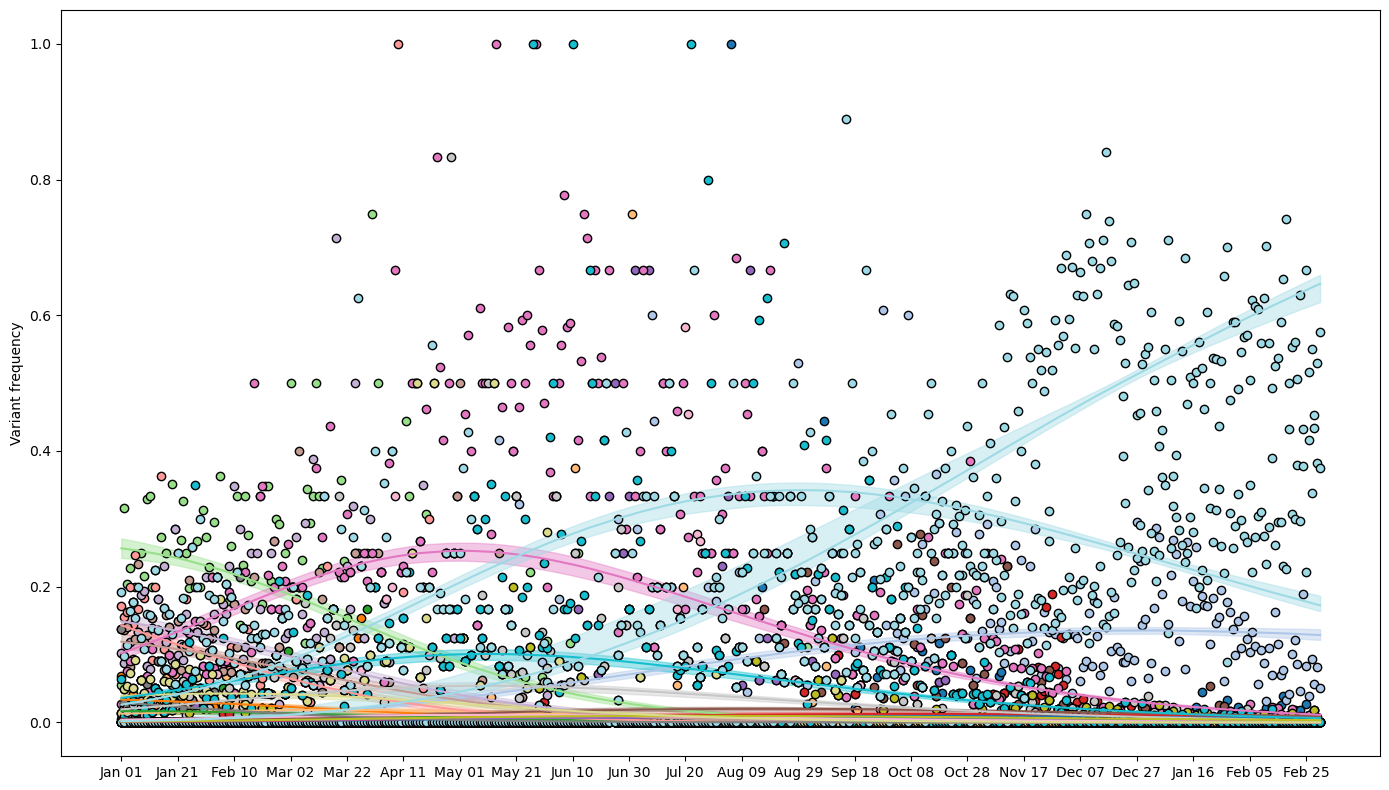

In [27]:
# Plot predicted frequencies
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

evofr.plotting.FrequencyPlot(posterior).plot(ax, forecast=False)
#add_dates_sep(ax, ef.data.expand_dates(variant_frequencies.dates, forecast_L), sep=30) # Adding dates
#PatchLegend(color_map).add_legend(ax)

fig.tight_layout()

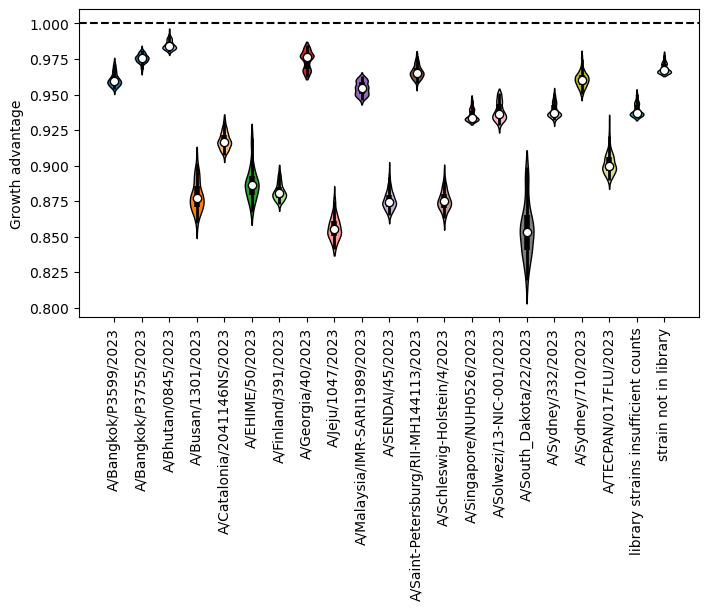

In [32]:
# Plotting growth advantage
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

evofr.plotting.GrowthAdvantagePlot(posterior).plot(ax=ax)

_ = plt.xticks(rotation=90)